In [22]:
"""
This block generates the train/test dataset.

[seg_id, text, sentiment] # text is replace with vocabulary ids

TODO:
embedding_lookup?
"""

import os
import csv
import pickle

train_ratio = 0.8
train_data_pkl = 'train_data.pkl'
test_data_pkl = 'test_data.pkl'


files = os.listdir('./Segmented/')
train_files = [f.split('.')[0] for f in files[:int(len(files) * train_ratio)]]
test_files = [f.split('.')[0] for f in files[int(len(files) * train_ratio):]]



csv_filename = "processed_labels_no_criteria_binary.csv"
csv_filename = "processed_labels_no_criteria_three_class.csv"
csv_filename = "processed_labels_no_criteria.csv"



sentiment_dict = {}
with open('../' + csv_filename, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        sentiment_dict[row[0]] = int(row[1])
        

voc_ids = {}
voc_ids_rev = {}

with open('./LanguageVocabulary.txt', 'r') as f:
    for row in f:
        row = row.split(' ')
        if len(row) < 3:
            continue
        k = row[0]
        v = row[1]
        voc_ids[v] = k
        voc_ids_rev[k] = v
        
        
train_data = []
test_data = []

for f in train_files:
    with open('./Segmented/' + f + '.annotprocessed', 'r') as s:
        for row in s:
            row = row.split('_DELIM_')
            seg_id = f + '_' + row[0]
            
            if seg_id not in sentiment_dict:    # some are filtered
                continue
                
            text = [voc_ids[w] for w in row[1].rstrip().split(' ') if w]
            train_data.append([seg_id, text, sentiment_dict[seg_id]])
            
for f in test_files:
    with open('./Segmented/' + f + '.annotprocessed', 'r') as s:
        for row in s:
            row = row.split('_DELIM_')
            seg_id = f + '_' + row[0]
            
            if seg_id not in sentiment_dict:    # some are filtered
                continue
                
            text = [voc_ids[w] for w in row[1].rstrip().split(' ') if w]
            test_data.append([seg_id, text, sentiment_dict[seg_id]])

            
with open(train_data_pkl, 'wb') as f:
    pickle.dump(train_data, f)
    
with open(test_data_pkl, 'wb') as f:
    pickle.dump(test_data, f)

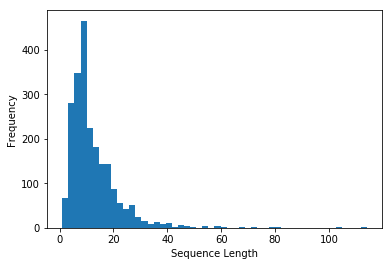

In [23]:
"""
some plots
"""

from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

total_data = train_data + test_data



plt.hist([len(t[1]) for t in total_data], 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

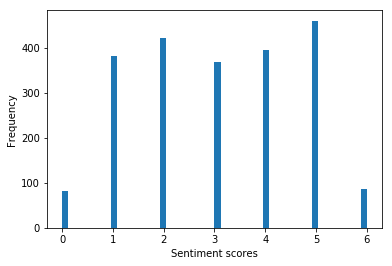

In [24]:
"""
use for multi-class
"""

plt.hist([t[2] for t in total_data], 50)
plt.xlabel('Sentiment scores')
plt.ylabel('Frequency')
plt.show()


In [25]:
"""
Defines helper functions for getting batches

labels are in one-hot format

suitable for binary or three classes
just change numClasses
"""

import numpy as np
from random import randint


batchSize = 256     # 64
maxSeqLength = 20
wordVecsLast = 3015


numClasses = 7      # 2, 3

# load pickle

def getTrainBatch():
    labels = np.zeros([batchSize, numClasses])
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(0, len(train_data) - 1)
        labels[i][train_data[num][2]] = 1
        data = train_data[num][1]
        if len(data) >= maxSeqLength:
            arr[i] = [k if int(k) <= wordVecsLast else 0 for k in data[:maxSeqLength]]
        else:
            arr[i] = [k if int(k) <= wordVecsLast else 0 for k in data] + [0] * (maxSeqLength - len(data))
    return arr, labels


def getTestBatch():
    labels = np.zeros([len(test_data), numClasses])
    arr = np.zeros([len(test_data), maxSeqLength])
    for i in range(len(test_data)):
        labels[i][test_data[i][2]] = 1
        data = test_data[i][1]
        if len(data) >= maxSeqLength:
            arr[i] = [k if int(k) <= wordVecsLast else 0 for k in data[:maxSeqLength]]
        else:
            arr[i] = [k if int(k) <= wordVecsLast else 0 for k in data] + [0] * (maxSeqLength - len(data))
    return arr, labels

# getTrainBatch()[1].shape

In [26]:
"""
RNN model
"""

import pickle
import numpy

# batchSize = 64      # already defined
# maxSeqLength = 20
lstmUnits = 64
# numClasses = 2
iterations = 100001   # 100001

wordVectors = None
with open('./glove_300_mosi.pkl', 'rb') as f:
    wordVectors = pickle.load(f, encoding='latin1').astype('float32')    # important encoding, type casting

numDimensions = wordVectors.shape[1]

In [27]:
import tensorflow as tf

num_layers = 1


tf.reset_default_graph()

keep_prob = tf.placeholder(tf.float32)        # keep_prob=1.0 when testing

labels = tf.placeholder(tf.float32, [None, numClasses])
input_data = tf.placeholder(tf.int32, [None, maxSeqLength])


# data = tf.Variable(tf.zeros([input_data.shape[0], maxSeqLength, numDimensions]), dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors, input_data)


def lstm_cell():
    lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=keep_prob)
    return lstmCell
    
lstmCell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_layers)])
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)



weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)


correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
# correctPred = tf.less(tf.abs(tf.subtract(tf.argmax(prediction,1), tf.argmax(labels,1))), 3)
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

C:\Users\chenf\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
import datetime

train_loss_sum = tf.summary.scalar('Train_Loss', loss)
train_accu_sum = tf.summary.scalar('Train_Accuracy', accuracy)

test_loss_sum = tf.summary.scalar('Test_Loss', loss)
test_accu_sum = tf.summary.scalar('Test_Accuracy', accuracy)

test_sum = tf.summary.merge([test_loss_sum, test_accu_sum])
train_sum = tf.summary.merge([train_loss_sum, train_accu_sum])


merged = tf.summary.merge_all()

logdir = "tensorboard/" + datetime.datetime.now().strftime('%Y%m%d-%H%M') + '/'


In [29]:
sess = tf.Session()
saver = tf.train.Saver()
writer = tf.summary.FileWriter(logdir, sess.graph)
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    nextBatch, nextBatchLabels = getTrainBatch();
    los, acc, _ = sess.run([loss, accuracy, optimizer], {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 0.6})
    
    
    if (i % 5000 == 0):
        print('Train', i, ':', los, ',', acc)
        
    if (i % 10000 == 0):
        nextBatch, nextBatchLabels = getTestBatch()
        los, acc, _ = sess.run([loss, accuracy, optimizer], {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 1.0})
        print('Test', i, ':', los, ',', acc)
        
    #Write summary to Tensorboard
    if (i % 50 == 0):
        train_s = sess.run(train_sum, {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 1.0})
        writer.add_summary(train_s, i)

        nextBatch, nextBatchLabels = getTestBatch()
        test_s = sess.run(test_sum, {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 1.0})
        writer.add_summary(test_s, i)
        
    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/" + csv_filename + ".ckpt", global_step=i)
        print("saved to %s" % save_path)
        
writer.close()

Train 0 : 2.19182 , 0.160156
Test 0 : 2.01986 , 0.218605
Train 5000 : 0.000455325 , 1.0
Train 10000 : 0.0197982 , 1.0
Test 10000 : 4.85799 , 0.25814
saved to models/processed_labels_no_criteria.csv.ckpt-10000
Train 15000 : 8.51455e-05 , 1.0
Train 20000 : 7.84965e-06 , 1.0
Test 20000 : 8.84445 , 0.3
saved to models/processed_labels_no_criteria.csv.ckpt-20000
Train 25000 : 5.8953e-06 , 1.0
Train 30000 : 1.11981e-05 , 1.0
Test 30000 : 6.66289 , 0.439535
saved to models/processed_labels_no_criteria.csv.ckpt-30000
Train 35000 : 0.00011949 , 1.0
Train 40000 : 5.44836e-05 , 1.0
Test 40000 : 5.0998 , 0.495349
saved to models/processed_labels_no_criteria.csv.ckpt-40000


KeyboardInterrupt: 

In [ ]:
import pandas as pd

nextBatch, nextBatchLabels = getTestBatch();
pred, _ = sess.run([prediction, optimizer], {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 1.0})
print(np.mean(np.argmax(nextBatchLabels, 1) == np.argmax(pred, 1)))
print(pd.DataFrame({
    'label' : np.argmax(nextBatchLabels, 1),
    'pred'  : np.argmax(pred, 1)
}))